# Setup and Import

In [ ]:
#!pip install statsmodels

In [ ]:
#!pip install sklearn

In [25]:
# importing required liberies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import statsmodels.api as sms
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [3]:
# reading data in our dataframe (df)
df = pd.read_csv('data/us_bank_wages.txt', sep='\t')
# changing column names into small letters
for c in df: df.rename(columns={c:c.lower()},inplace=True)
df.head()


,unnamed: 0,salary,educ,salbegin,gender,minority,jobcat
0,0,57000,15,27000,1,0,3
1,1,40200,16,18750,1,0,1
2,2,21450,12,12000,0,0,1
3,3,21900,8,13200,0,0,1
4,4,45000,15,21000,1,0,1


# Getting to know the data

In [ ]:
df.info()
df.columns

In [4]:
# dropping out the unnamed column, since it does not bring us any value
df = df.drop(index=0)
df = df.drop(["unnamed: 0"],axis = 1)
df.reset_index(drop = True)

df.head(3)

,salary,educ,salbegin,gender,minority,jobcat
1,40200,16,18750,1,0,1
2,21450,12,12000,0,0,1
3,21900,8,13200,0,0,1


# Hypothesis: 
1.) We expect positive estimators for education, gender and salbegin. 
* better education leads to higher salary
* higher first salary (salbegin) leads to higher salary
* we expect higher incomes for males than females

Thus, for educ, salbin and gender we have the following hypothesis:

 $  H_0: \beta_i = 0 $ vs. $ H_1: \beta_i > 0 $ , where i = educ, salbegin or gender 

2.) We should have a negative estimator for the minority feature
* we expect higher income for non-minorities than minorities

For the minority feature we have the following hypothesis:
 $  H_0: \beta_{minority} = 0 $ vs. $ H_1: \beta_{minority} < 0 $

# Visualisation
Now lets see whether our hypothesis can be supported or rejected via visualisation.

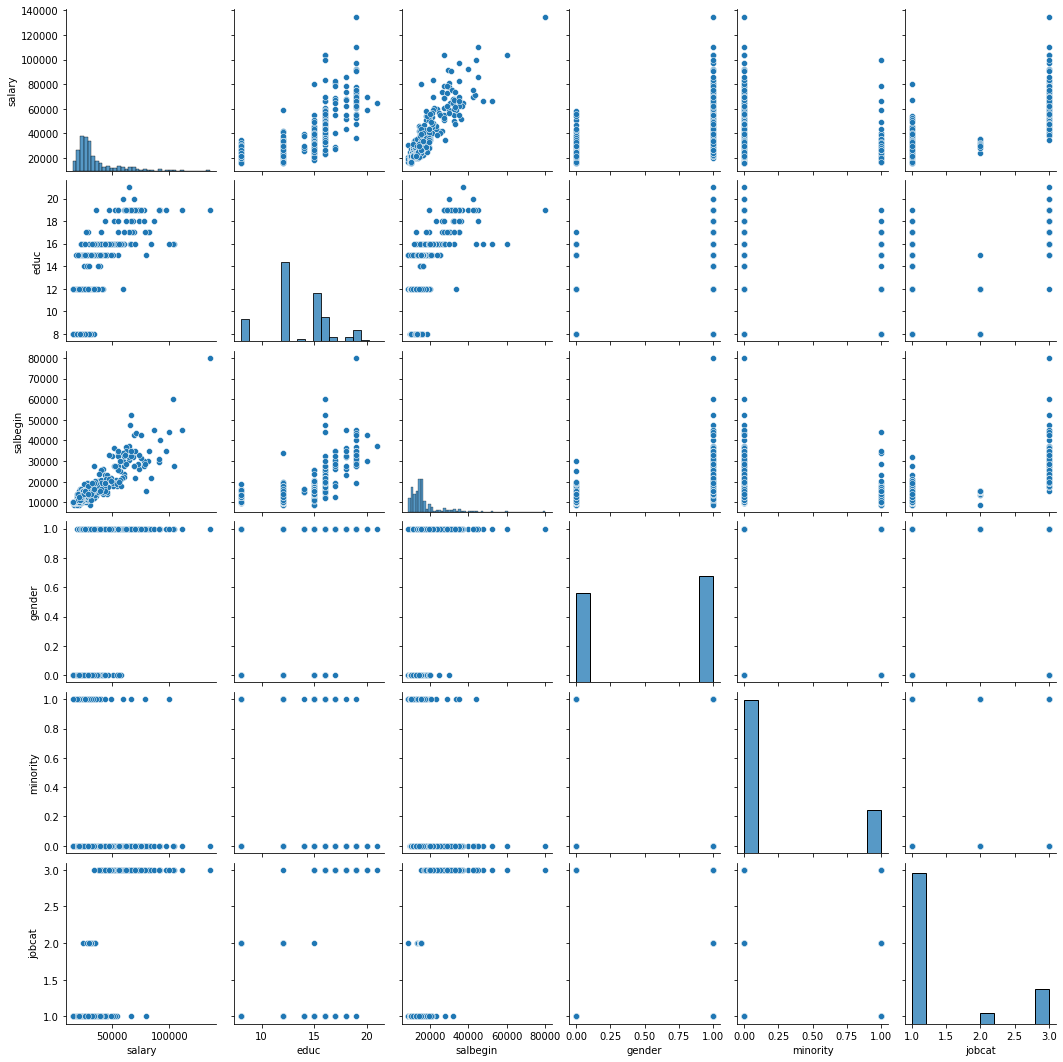

In [6]:
sns.pairplot(vars=['salary','educ', 'salbegin', 'gender', 'minority',
       'jobcat'],data=df)

What we learn from the pairplot:
* The salary row of our pairplot indicates, that education and salbegin have a positive impact on salary. 
* Moreover we have 3 categorical variables/dummys, where femals and minorities earn less, and jobcatagory  management positions earn more than the other two jobcats. For a better overview see figure below.
* we dont have a normal distribution for salbegin, which could lead to problems in our t-test later.

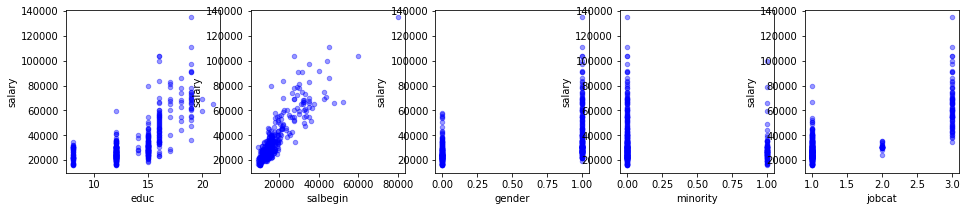

In [52]:
# scatterplots for the each feature on salary
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,3))

for xcol, ax in zip(['educ', 'salbegin', 'gender', 'minority',
       'jobcat'], axes):
    df.plot(kind='scatter', x=xcol, y='salary', ax=ax, alpha=0.4, color='b')

In [63]:
#px.histogram(df,x='salbegin',template='plotly_dark', title='salbegin distribution')

From the pairplot we saw that the distribution of salbegin is right-taled skewed. This could imply that salbegin has a non-linear relation to salary. Via the natural log, I try to address the problem.

In [64]:
#px.histogram(df,x='lsalbegin',template='plotly_dark', title='log(salbegin) distribution')

In [61]:
df['lsalary'] = np.log(df['salary'])
df['lsalbegin'] = np.log(df['salbegin'])
df.head(3)

,salary,educ,salbegin,gender,minority,jobcat,lsalary,lsalbegin
1,40200,16,18750,1,0,1,10.601622,9.838949
2,21450,12,12000,0,0,1,9.973480,9.392662
3,21900,8,13200,0,0,1,9.994242,9.487972


As you can see below, we can decrease the skewness of salbegin and salary via the natural log.

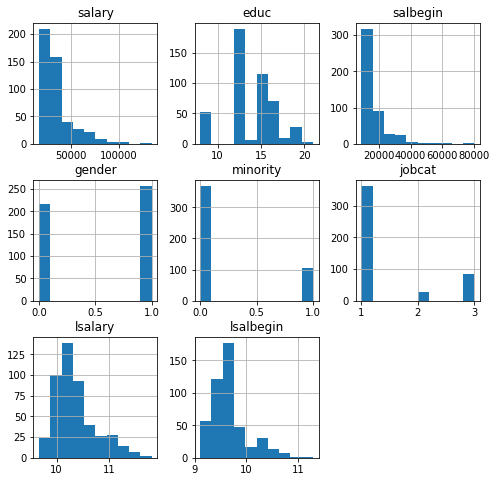

In [62]:
# lsalbegin is the natural log of salbegin and lsalary is the natural log of salary.
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
df.hist(ax = ax);

Via the natural logarithm, we also address the outlier problem.

In [40]:
px.box(df,x='salbegin',template='plotly_dark',points='all',title="salbegin boxplot and outliers")

In [41]:
px.box(df,x='lsalbegin',template='plotly_dark',points='all',title="log(salbegin) boxplot and outliers")

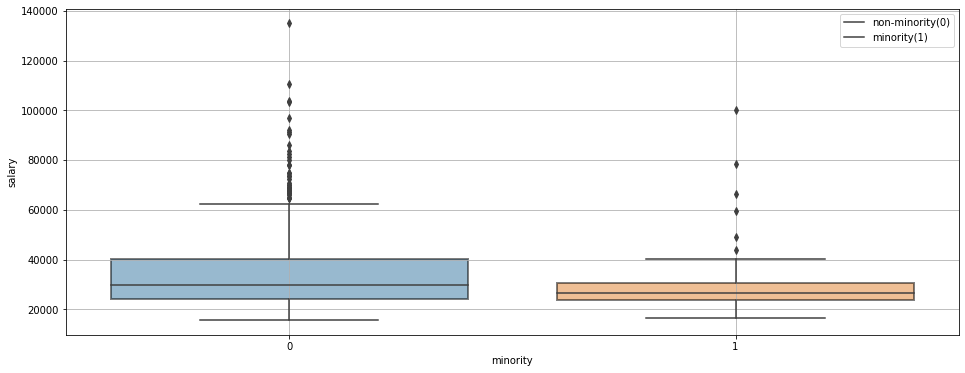

In [65]:
# Boxplot 1: non-minority vs. minority
plt.figure(figsize = (16, 6))
ax = sns.boxplot(x='minority', y='salary', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks()
plt.legend(["non-minority(0)", "minority(1)"])
ax.grid(True);

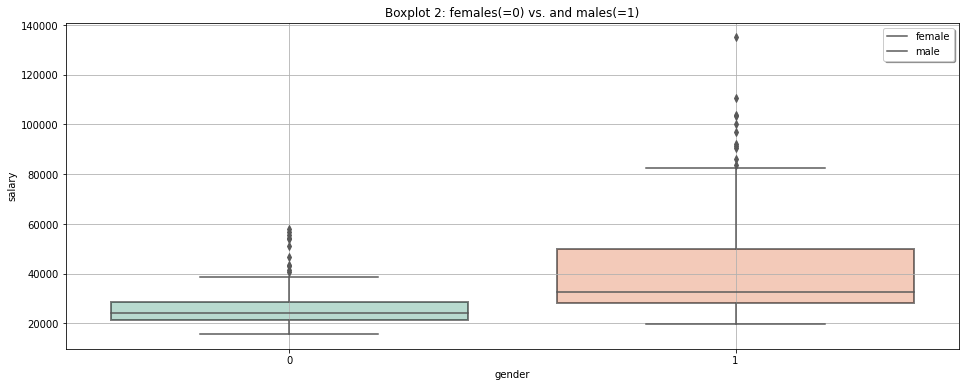

In [66]:
# Boxplot 2: females(=0) vs. and males(=1)
plt.figure(figsize = (16, 6))
ax = sns.boxplot(x='gender', y='salary',palette="Set2",data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=0)
plt.title('Boxplot 2: females(=0) vs. and males(=1)')
plt.legend(["female", "male"],shadow=True)
ax.grid(True);


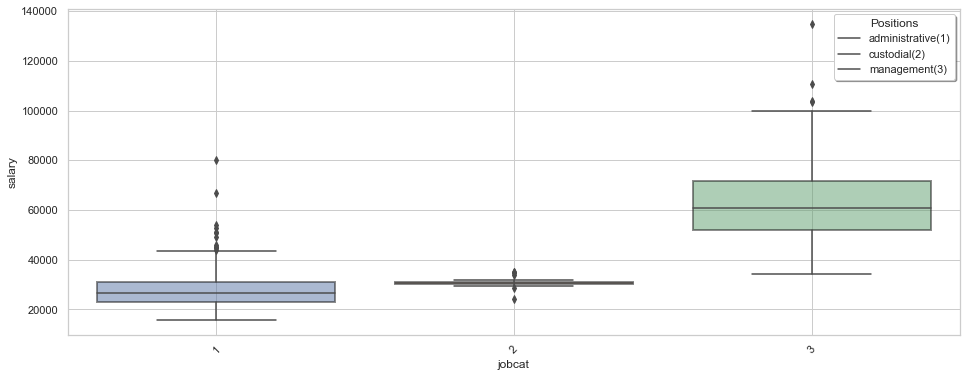

In [146]:
# boxplot 3 for jobcatagories
plt.figure(figsize = (16, 6))
ax = sns.boxplot(x='jobcat', y='salary', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.legend(["administrative(1)", "custodial(2)", "management(3)"],title='Positions',shadow=True)
ax.grid(True);

Boxplots show the differences inside our categories:
* A difference between whites and minorities is hard to see. Hypothesis from 2) is hard to reject.
* the second boxplot confirms a gender gap: females earn less, which supports $$ \beta_{gender} > 0 $$
* the third boxplot shows that those in management positions earn more than those in custodial or administrative positions

In [141]:
# Addressing the dummy variable trap. This is useful for the linear regression later and for the correlation matrix below
jc_dummies = pd.get_dummies(df['jobcat'], prefix='jobcat', drop_first=True)
df_d = df.drop(['jobcat'], axis=1)

df_d = pd.concat([df_d, jc_dummies], axis=1)
df_d.head(3)


,salary,educ,salbegin,gender,minority,lsalary,lsalbegin,cat_educ,jobcat_2,jobcat_3
1,40200,16,18750,1,0,10.601622,9.838949,university,0,0
2,21450,12,12000,0,0,9.973480,9.392662,high school,0,0
3,21900,8,13200,0,0,9.994242,9.487972,junior high,0,0


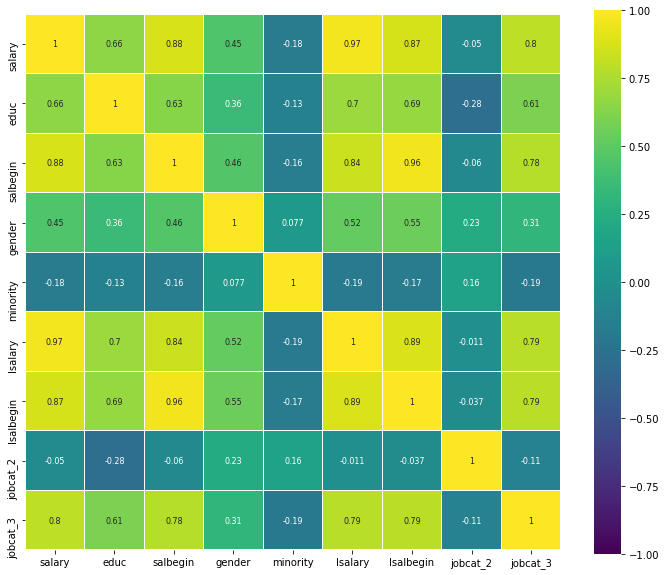

In [142]:
# heatmap for the correlation matrix
corr=df_d.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

The heatmap above gives us many insightful information. But we concentrate on the lsalary row. There we see that our null hypothesis in 1) can be rejected, i.e. educ, salbegin/lsalbegin and gender have a positive impact on lsalary.

In [117]:
edu=df['educ']
def map_educ(edu):
    if edu == 8: return "junior high"
    elif edu == 12: return "high school"
    elif edu > 12: return "university"
df["cat_educ"] = df.educ.apply(map_educ).astype("category")
df

,salary,educ,salbegin,gender,minority,jobcat,lsalary,lsalbegin,cat_educ
1,40200,16,18750,1,0,1,10.601622,9.838949,university
2,21450,12,12000,0,0,1,9.973480,9.392662,high school
3,21900,8,13200,0,0,1,9.994242,9.487972,junior high
4,45000,15,21000,1,0,1,10.714418,9.952278,university
5,32100,15,13500,1,0,1,10.376611,9.510445,university
...,...,...,...,...,...,...,...,...,...
469,26250,12,15750,1,1,1,10.175421,9.664596,high school
470,26400,15,15750,1,1,1,10.181119,9.664596,university
471,39150,15,15750,1,0,1,10.575156,9.664596,university
472,21450,12,12750,0,0,1,9.973480,9.453287,high school


Text(0.5, 1.0, 'Education level as catagory on lsalary')

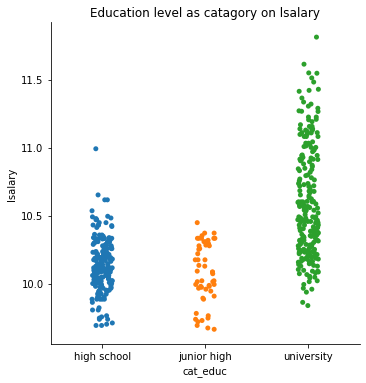

In [146]:
sns.catplot(x='cat_educ', y='lsalary',data=df)
plt.title('Education level as catagory on lsalary')

In the last two cells a new column was created where educ was transformed into a categorical variable. Now we can see clearer that those with a university degree have in general higher salaries than those with a high school or junior high level.

## Linear Regression Model
Now we want to derive a good linear regression model via OLS.

In [151]:
X1 = df_d[['educ','lsalbegin', 'gender', 'minority', 'jobcat_2',
       'jobcat_3']]

X1 = sms.add_constant(X1)
y1 = df_d.lsalary

model = sms.OLS(y1, X1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lsalary   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     366.9
Date:                Wed, 17 Feb 2021   Prob (F-statistic):          5.39e-173
Time:                        15:32:23   Log-Likelihood:                 179.14
No. Observations:                 473   AIC:                            -344.3
Df Residuals:                     466   BIC:                            -315.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1233      0.415      9.947      0.000       3.309       4.938
educ           0.0247      0.004      6.258      0.000       0.017       0.032
lsalbegin      0.6027      0.046     13.234      0.000       0.513       0.692
gender         0.0593      0.020      2.959      0.003       0.020       0.099
minority      -0.0431      0.019     -2.227      0.026      -0.081      -0.005
jobcat_2       0.1285      0.037      3.443      0.001       0.055       0.202
jobcat_3       0.2386      0.034      6.919      0.000       0.171       0.306
==============================================================================
Omnibus:                       49.306   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.694
Skew:                           0.645   Prob(JB):                     9.07e-20
Kurtosis:                       4.669   Cond. No.                         916.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
model = smf.ols('lsalary ~  educ+ C(jobcat) + gender + lsalbegin+ minority+ +C(jobcat)*minority',data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lsalary   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     276.9
Date:                Wed, 17 Feb 2021   Prob (F-statistic):          2.56e-171
Time:                        14:44:13   Log-Likelihood:                 181.23
No. Observations:                 473   AIC:                            -344.5
Df Residuals:                     464   BIC:                            -307.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.2430      0.418     10.148      0.000       3.421       5.065
C(jobcat)[T.2]              0.1032      0.049      2.127      0.034       0.008       0.199
C(jobcat)[T.3]              0.2327      0.035      6.741      0.000       0.165       0.301
educ                        0.0256      0.004      6.454      0.000       0.018       0.033
gender                      0.0619      0.020      3.087      0.002       0.022       0.101
lsalbegin                   0.5892      0.046     12.818      0.000       0.499       0.679
minority                   -0.0576      0.021     -2.761      0.006      -0.099      -0.017
C(jobcat)[T.2]:minority     0.0641      0.067      0.950      0.342      -0.068       0.197
C(jobcat)[T.3]:minority     0.1654      0.089      1.859      0.064      -0.009       0.340
==============================================================================
Omnibus:                       48.688   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.628
Skew:                           0.634   Prob(JB):                     9.37e-20
Kurtosis:                       4.685   Cond. No.                         926.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear regression results:
In the first model summary, we can see that all features have a p-value less than 0.05 and hence are statistically significant. In the second model summary, I have included a cross variable term between jobcat and minority. However, the interaction of the jobcat dummies and minority had a p-value above 0.05.

After all, the combination of AIC, BIV and R^2 imply the following as the the best model:

$$ log(salary) = 4.123	 + 0.603*x_{lsalbegin} + 0.025*x_{educ} + 0.059*x_{male}-0.0431*x_{minority}+ 0.239*x_{management} +0.129*x_{custodial}$$ 

Conclusion: We can know reject all our null hypothesis from the hypothesis 1) and 2), i.e. our assumptions are supported by the data after the OLS method


Now  we turn our focus on the train test split method, where we split the data into train and test, in order to train and then test the model

In [182]:
features = df_d[['educ','lsalbegin', 'gender', 'minority', 'jobcat_2',
       'jobcat_3']]
target = df.lsalary
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 465)
print('Training Data Count: {}'.format(X_train.shape[0]))

print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 331
Testing Data Count: 142


In [185]:
X_train = sms.add_constant(X_train)

results = sms.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lsalary   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     238.0
Date:                Wed, 17 Feb 2021   Prob (F-statistic):          1.56e-115
Time:                        16:16:25   Log-Likelihood:                 126.17
No. Observations:                 331   AIC:                            -238.3
Df Residuals:                     324   BIC:                            -211.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8226      0.507      7.533      0.000       2.824       4.821
educ           0.0230      0.005      4.850      0.000       0.014       0.032
lsalbegin      0.6362      0.056     11.385      0.000       0.526       0.746
gender         0.0612      0.024      2.536      0.012       0.014       0.109
minority      -0.0421      0.023     -1.818      0.070      -0.088       0.003
jobcat_2       0.1254      0.044      2.834      0.005       0.038       0.213
jobcat_3       0.1901      0.043      4.382      0.000       0.105       0.275
==============================================================================
Omnibus:                       52.158   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.317
Skew:                           0.814   Prob(JB):                     6.73e-25
Kurtosis:                       5.328   Cond. No.                         929.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
font = {'family': 'Arial',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }

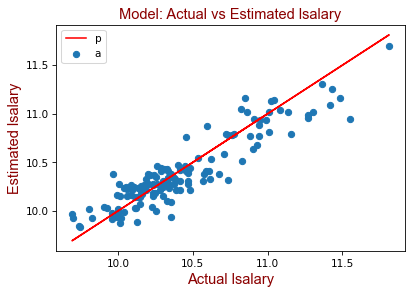

In [186]:
# now lets include the test dataset and make a prediction with it on our trained model

X_test = sms.add_constant(X_test)
y_preds = results.predict(X_test)

plt.figure(dpi = 75)

plt.scatter(y_test, y_preds)

plt.plot(y_test, y_test, color="red")

plt.xlabel("Actual lsalary", fontdict=font)

plt.ylabel("Estimated lsalary", fontdict=font)
plt.legend('pa')

plt.title("Model: Actual vs Estimated lsalary", fontdict=font)

plt.show()



In [173]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

In [187]:
print("Mean Absolute Error (MAE)         : {}".format(mean_absolute_error(y_test, y_preds)))

print("Mean Squared Error (MSE) : {}".format(mse(y_test, y_preds)))

print("Root Mean Squared Error (RMSE) : {}".format(rmse(y_test, y_preds)))

Mean Absolute Error (MAE)         : 0.13021677149828348
Mean Squared Error (MSE) : 0.028557952886917686
Root Mean Squared Error (RMSE) : 0.16899098463207346
Mean Absolute Perc. Error (MAPE) : 1.2396899225974332


In [197]:
# Now we take the model where we drop minority feature
features2 = df_d[['educ','lsalbegin', 'gender', 'jobcat_2',
       'jobcat_3']]
target = df.lsalary
X2_train, X2_test, y2_train, y2_test = train_test_split(features2, target, test_size = 0.3, random_state = 465)
print('Training Data Count: {}'.format(X2_train.shape[0]))
print('Testing Data Count: {}'.format(X2_test.shape[0]))

Training Data Count: 331
Testing Data Count: 142


In [198]:
X2_train = sms.add_constant(X2_train)

results2 = sms.OLS(y2_train, X2_train).fit()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lsalary   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     283.0
Date:                Wed, 17 Feb 2021   Prob (F-statistic):          4.55e-116
Time:                        16:28:17   Log-Likelihood:                 124.49
No. Observations:                 331   AIC:                            -237.0
Df Residuals:                     325   BIC:                            -214.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6989      0.505      7.329      0.000       2.706       4.692
educ           0.0224      0.005      4.728      0.000       0.013       0.032
lsalbegin      0.6492      0.056     11.673      0.000       0.540       0.759
gender         0.0536      0.024      2.248      0.025       0.007       0.100
jobcat_2       0.1175      0.044      2.658      0.008       0.031       0.204
jobcat_3       0.1945      0.043      4.475      0.000       0.109       0.280
==============================================================================
Omnibus:                       55.563   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.316
Skew:                           0.846   Prob(JB):                     1.01e-27
Kurtosis:                       5.481   Cond. No.                         921.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

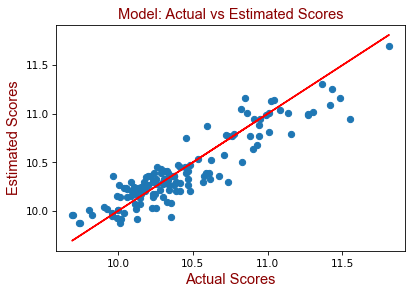

In [201]:
X2_test = sms.add_constant(X2_test)
y2_preds = results2.predict(X2_test)

plt.figure(dpi = 75)

plt.scatter(y2_test, y2_preds)

plt.plot(y2_test, y2_test, color="red")

plt.xlabel("Actual Scores", fontdict=font)

plt.ylabel("Estimated Scores", fontdict=font)

plt.title("Model: Actual vs Estimated Scores", fontdict=font)

plt.show()


Just by looking the figures, we cant say which model is better. Therefore we should compare the RMSE to make a decision.

In [202]:
print("Mean Absolute Error (MAE)         : {}".format(mean_absolute_error(y2_test, y2_preds)))

print("Mean Squared Error (MSE) : {}".format(mse(y2_test, y2_preds)))

print("Root Mean Squared Error (RMSE) : {}".format(rmse(y2_test, y2_preds)))

Mean Absolute Error (MAE)         : 0.13034212614926913
Mean Squared Error (MSE) : 0.028876351236696213
Root Mean Squared Error (RMSE) : 0.16993043057879956
Mean Absolute Perc. Error (MAPE) : 1.2414099182758254


In [203]:
print("Root Mean Squared Error train_test_1(RMSE) : {}".format(rmse(y_test, y_preds)))
print("Root Mean Squared Error train_test_2(RMSE) : {}".format(rmse(y2_test, y2_preds)))


Root Mean Squared Error train_test_1(RMSE) : 0.16899098463207346
Root Mean Squared Error train_test_2(RMSE) : 0.16993043057879956
